<a href="https://colab.research.google.com/github/alminha021/DS-rcf/blob/main/Infec%C3%A7%C3%A3o_virus_matrizesferica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raul C. Feitosa

# **Matriz esférica- teste de infecção**

Dada uma matriz n x n esférica:
- paciente 0 adquire a doença
- 5% da população ja é resistente a nova doença
- simular paciente deslocando e infectando
- individuos sintomáticos e assintomáticos, ambos infectam
- risco de morte para pacientes sintomáticos no estado grave
- imunidade após 20 passos do individuo adquirir a condição de infectado

In [277]:
import random
import numpy as np
import pandas as pd

n = 50  # tamanho da matriz
total_passos = 365
passos_imunidade = 20

# Label
SADIO = '.'
INFECTADO = 'a'
RESISTENTE = '-'
IMUNE = '^'
MORTO = '@'
SINTOMATICO = 'S'
GRAVE = 'G'

prob_sintomatico = 0.20
prob_grave = 0.1
prob_morte_grave = 0.8

# Inicialização da matriz
matriz = np.full((n, n), SADIO)
tempo_infectado = np.full((n, n), -1)

infectado_inicial = (random.randint(0, n-1), random.randint(0, n-1))
matriz[infectado_inicial] = INFECTADO
tempo_infectado[infectado_inicial] = 0

num_resistentes = int(n * n * 0.05)
resistentes_posicoes = random.sample([(i, j) for i in range(n) for j in range(n) if (i, j) != infectado_inicial], num_resistentes)
for pos in resistentes_posicoes:
    matriz[pos] = RESISTENTE


def obter_vizinhos(pos):
    """Retorna os vizinhos diretos de uma posição, considerando a borda esférica."""
    i, j = pos
    return [
        ((i - 1) % n, j),
        ((i + 1) % n, j),
        (i, (j - 1) % n),
        (i, (j + 1) % n)
    ]

def mover_jogador(matriz, pos, direcao):
    """Move o jogador na direção desejada."""
    i, j = pos
    if direcao == 'cima':
        nova_pos = ((i - 1) % n, j)
    elif direcao == 'baixo':
        nova_pos = ((i + 1) % n, j)
    elif direcao == 'esquerda':
        nova_pos = (i, (j - 1) % n)
    elif direcao == 'direita':
        nova_pos = (i, (j + 1) % n)
    matriz[i][j], matriz[nova_pos[0]][nova_pos[1]] = matriz[nova_pos[0]][nova_pos[1]], matriz[i][j]
    return nova_pos

def transformar_vizinhos(matriz, i, j):
    """Transforma os vizinhos diretos em infectados ou sintomáticos/graves."""
    vizinhos = obter_vizinhos((i, j))
    for ni, nj in vizinhos:
        if matriz[ni][nj] == SADIO:
            if random.random() < prob_sintomatico:
                matriz[ni][nj] = SINTOMATICO
                tempo_infectado[ni][nj] = 0
                if random.random() < prob_grave:
                    matriz[ni][nj] = GRAVE
            else:
                matriz[ni][nj] = INFECTADO
                tempo_infectado[ni][nj] = 0
        #elif matriz[ni][nj] == SINTOMATICO:
         #   if random.random() < prob_grave:
          #        matriz[ni][nj] = GRAVE

def imprimir_matriz(matriz, passo):
    """Exibe a matriz no console."""
    print(f"Passo {passo}:")
    for linha in matriz:
        print(' '.join(linha))
    print("\n")

# DataFrame para armazenar os dados a cada passo
dados = pd.DataFrame(columns=['Passo', 'Assintomáticos', 'Sintomáticos', 'Graves', 'Mortos', 'Curados'])

print('-Paciente ZERO e Resistentes')
imprimir_matriz(matriz, 0)

# Simulação
print('-Infecção iniciada')
for passo in range(1,600 ):
    infectados_atuais = list(zip(*np.where((matriz == INFECTADO) | (matriz == SINTOMATICO) | (matriz == GRAVE))))
    novas_posicoes = []

    for inf_pos in infectados_atuais:
        direcao = random.choice(['cima', 'baixo', 'esquerda', 'direita'])
        nova_pos = mover_jogador(matriz, inf_pos, direcao)
        novas_posicoes.append(nova_pos)

    for nova_pos in novas_posicoes:
        i, j = nova_pos
        if matriz[i][j] in [INFECTADO, SINTOMATICO, GRAVE]:
            transformar_vizinhos(matriz, i, j)

        if matriz[i][j] == GRAVE and random.random() < prob_morte_grave:
            matriz[i][j] = MORTO

    # Atualiza o tempo de infecção e transforma infectados em imunes
    for i in range(n):
        for j in range(n):
            if matriz[i][j] in [INFECTADO, SINTOMATICO, GRAVE]:
                tempo_infectado[i][j] += 1
                if tempo_infectado[i][j] >= passos_imunidade:
                    matriz[i][j] = IMUNE

    # Estatísticas no final de cada passo e adiciona os dados ao DataFrame
    num_sadios = np.sum(matriz == SADIO)
    num_assintomaticos = np.sum(matriz == INFECTADO)
    num_sintomaticos = np.sum(matriz == SINTOMATICO)
    num_graves = np.sum(matriz == GRAVE)
    num_mortos = np.sum(matriz == MORTO)
    num_curados = np.sum(matriz == IMUNE)
    num_resistente = np.sum(matriz == RESISTENTE)


    imprimir_matriz(matriz, passo)
    print(f"Sadios:{num_sadios},Assintomáticos: {num_assintomaticos}, Sintomáticos: {num_sintomaticos}, Graves: {num_graves}, Mortos: {num_mortos}, Curados: {num_curados}, Resistentes: {num_resistente}")
    print(' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

    nova_linha = pd.DataFrame([{
        'Passo': passo,
        'Sadios': num_sadios,
        'Assintomáticos': num_assintomaticos,
        'Sintomáticos': num_sintomaticos,
        'Graves': num_graves,
        'Mortos': num_mortos,
        'Curados': num_curados,
        'Resistentes': num_resistente
    }])
    dados = pd.concat([dados, nova_linha], ignore_index=True)
    if num_assintomaticos == 0 and num_sintomaticos == 0 and num_graves == 0:
        break


print("Teste de Infecção Concluida")
# Salvar os dados em um arquivo CSV
dados.to_csv('dados_infeccao.csv', index=False)
pattern = [
    " ######    ####    ##   ##",
    " ##         ##     ### ###",
    " ##         ##     #######",
    " ####       ##     ## # ##",
    " ##         ##     ##   ##",
    " ##         ##     ##   ##",
    " ##        ####    ##   ##"
]


-Paciente ZERO e Resistentes
Passo 0:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . -
. . . . . . . . . . . . . . . . - . . . . . . . . . . . . . . . . . . . . - . . . . . . . . . . . .
. . . . . . - . . . . . - . . . . . - . . . . . . . - . . . . . . . . . . . . . . - . . . . . . . .
. . . . . . . - . . . . . . . . . - . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . - . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . - .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . - . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . - . . . . . . . -
- . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . - . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . - 

In [278]:
#dados.describe()

#csv

In [279]:
dados.head()

,Passo,Assintomáticos,Sintomáticos,Graves,Mortos,Curados,Sadios,Resistentes
0,1,4,1,0,0,0,2370.0,125.0
1,2,14,4,0,0,0,2357.0,125.0
2,3,29,6,0,0,0,2340.0,125.0
3,4,56,12,1,0,0,2306.0,125.0
4,5,91,18,1,1,0,2264.0,125.0


# **Estatística Descritiva**

In [280]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [281]:
sad = dados['Sadios']
sint = dados['Sintomáticos']
assint = dados['Assintomáticos']
graves = dados['Graves']
mortos = dados['Mortos']
curados = dados['Curados']


In [282]:
dados['numero_infectados'] = dados['Assintomáticos']+dados['Sintomáticos']+dados['Graves']

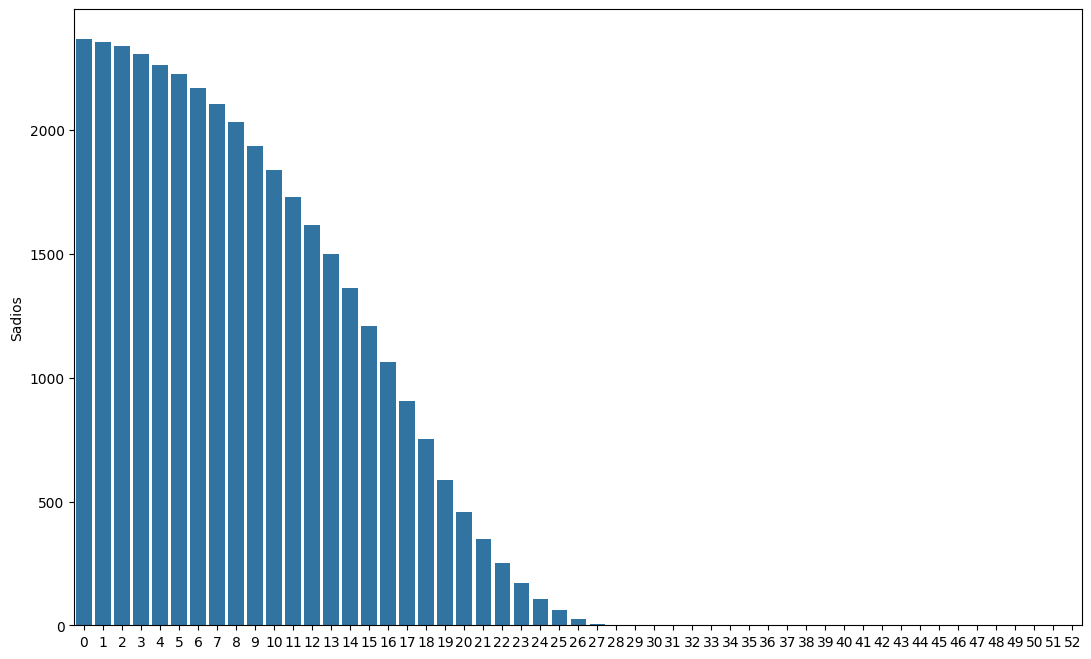

In [283]:
ax = sns.barplot(data=dados['Sadios'])
ax.figure.set_size_inches(13, 8)

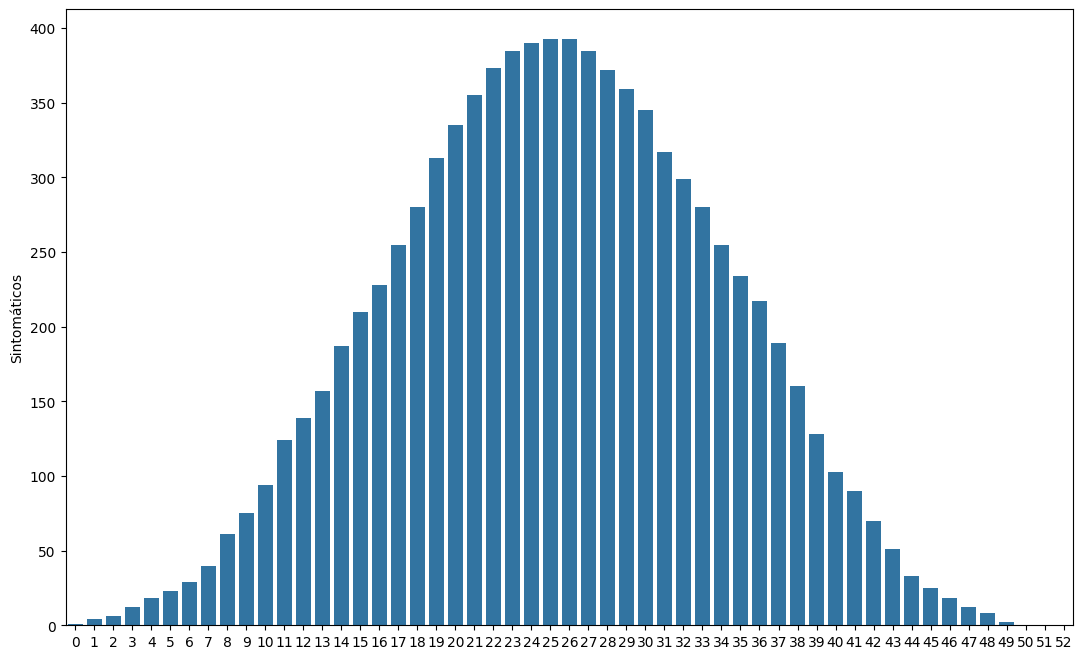

In [284]:
ax = sns.barplot(data=dados['Sintomáticos'])
#ax.bar_label(ax.containers[0], fontsize=10)
ax.figure.set_size_inches(13, 8)

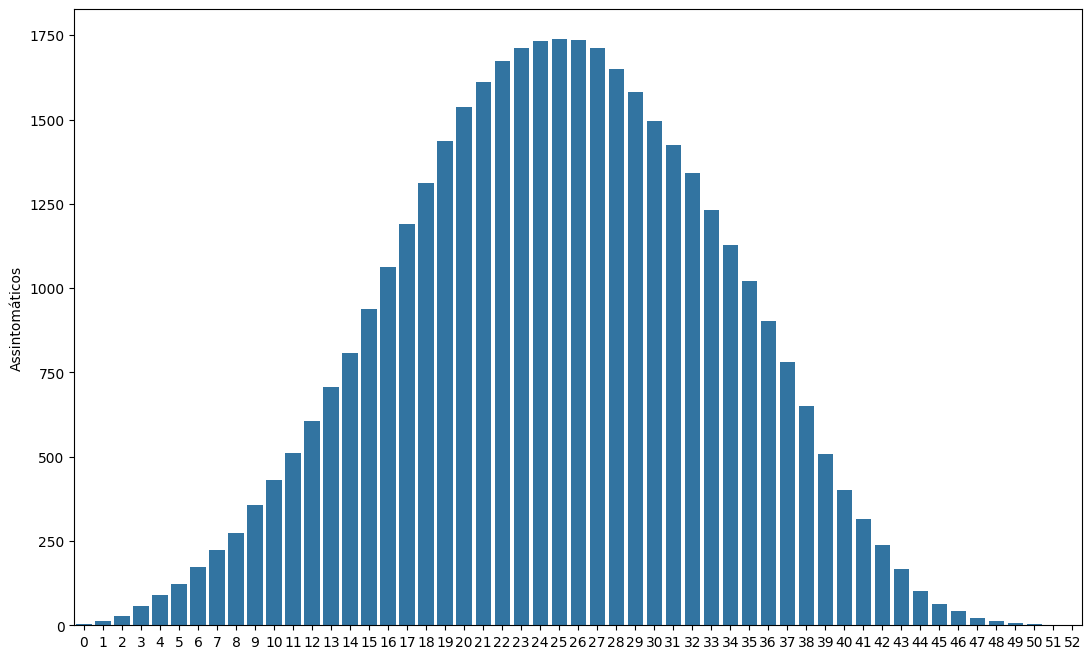

In [285]:
ax = sns.barplot(data=dados['Assintomáticos'])
ax.figure.set_size_inches(13, 8)

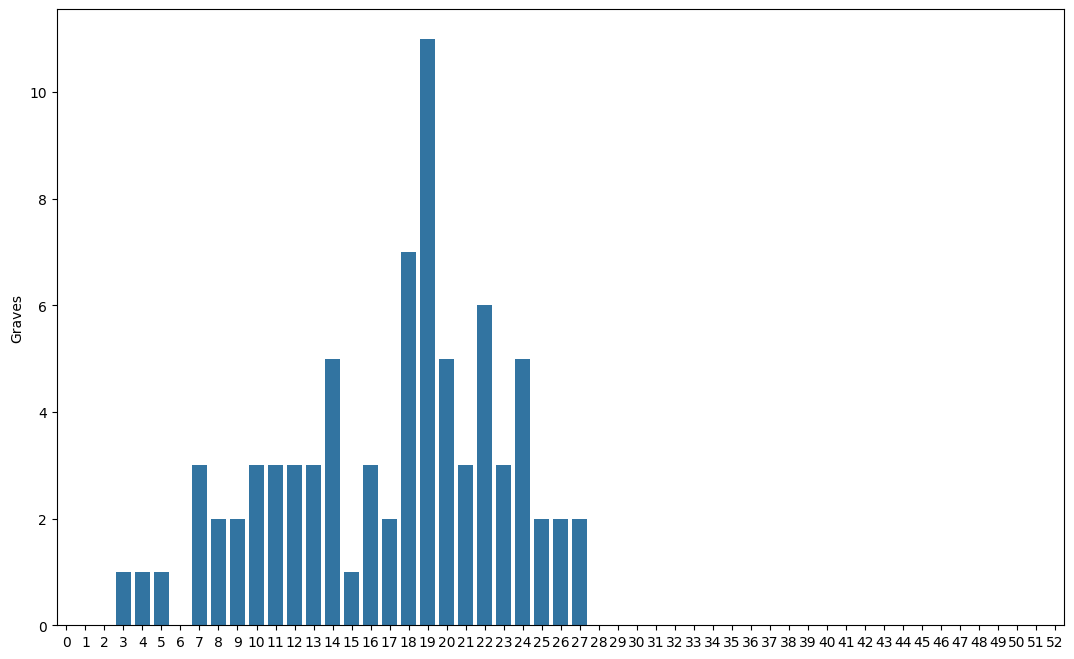

In [286]:
ax = sns.barplot(data=dados['Graves'])
ax.figure.set_size_inches(13, 8)

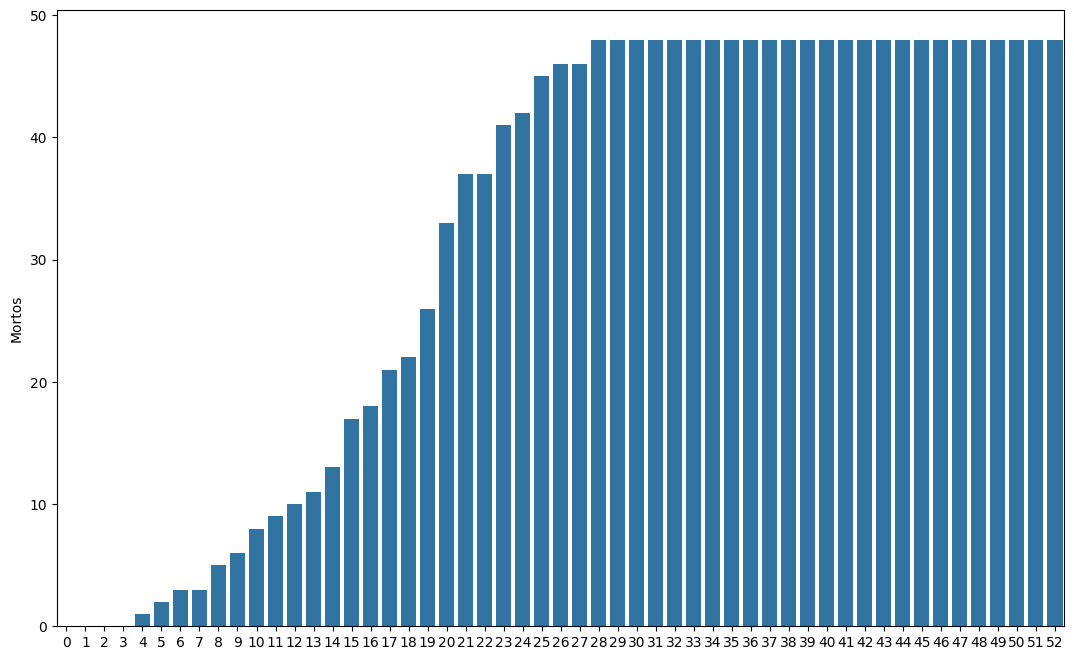

In [287]:
ax = sns.barplot(data=dados['Mortos'])
ax.figure.set_size_inches(13, 8)

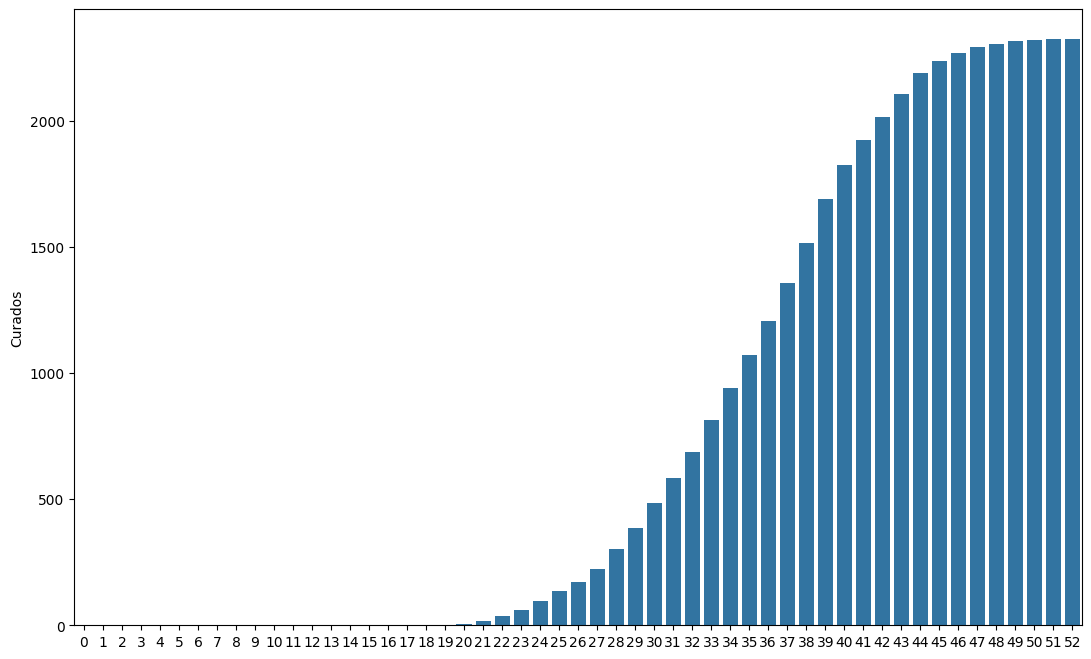

In [288]:
ax = sns.barplot(data=dados['Curados'])
ax.figure.set_size_inches(13, 8)

In [289]:
sad_int = sad.astype(int)
sint_int = sint.astype(int)
assint_int = assint.astype(int)
graves_int = graves.astype(int)
mortos_int = mortos.astype(int)
curados_int = curados.astype(int)

In [290]:
dados_int = dados.astype(int)

In [291]:
dados_int.describe()

,Passo,Assintomáticos,Sintomáticos,Graves,Mortos,Curados,Sadios,Resistentes,numero_infectados
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0,53.000000
mean,27.000000,733.943396,166.641509,1.490566,32.113208,759.698113,681.113208,125.0,902.075472
std,15.443445,638.626062,141.701894,2.249980,19.268009,926.533419,902.207819,0.0,781.153187
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.0,0.000000
25%,14.000000,103.000000,25.000000,0.000000,11.000000,0.000000,0.000000,125.0,136.000000
50%,27.000000,606.000000,139.000000,0.000000,46.000000,173.000000,25.000000,125.0,748.000000
75%,40.000000,1341.000000,299.000000,3.000000,48.000000,1690.000000,1498.000000,125.0,1640.000000
max,53.000000,1740.000000,393.000000,11.000000,48.000000,2327.000000,2370.000000,125.0,2135.000000


In [292]:
print('Mediana - Assintomáticos:',assint_int.median())
print('Mediana - Sintmáticos:',sint_int.median())
print('Mediana - Graves:',graves_int.median())
print('Mediana - Mortos:',mortos_int.median())
print('Mediana - Curados:',curados_int.median())
print('Mediana - Sadios:',sad_int.median())

Mediana - Assintomáticos: 606.0
Mediana - Sintmáticos: 139.0
Mediana - Graves: 0.0
Mediana - Mortos: 46.0
Mediana - Curados: 173.0
Mediana - Sadios: 25.0


In [293]:
import plotly.express as px
df = dados_int
fig = px.box(df)
fig.show()

In [294]:
infect = dados['numero_infectados']

In [295]:
infect_int = infect.astype(int)

In [296]:
infect_int.describe()

count      53.000000
mean      902.075472
std       781.153187
min         0.000000
25%       136.000000
50%       748.000000
75%      1640.000000
max      2135.000000
Name: numero_infectados, dtype: float64

In [297]:
infect_int

0        5
1       18
2       35
3       69
4      110
5      147
6      203
7      265
8      338
9      433
10     529
11     637
12     748
13     866
14    1001
15    1149
16    1294
17    1446
18    1600
19    1761
20    1878
21    1970
22    2052
23    2101
24    2127
25    2135
26    2131
27    2098
28    2023
29    1941
30    1842
31    1741
32    1640
33    1513
34    1384
35    1256
36    1119
37     971
38     810
39     637
40     503
41     404
42     309
43     219
44     136
45      89
46      59
47      33
48      21
49       9
50       4
51       1
52       0
Name: numero_infectados, dtype: int64

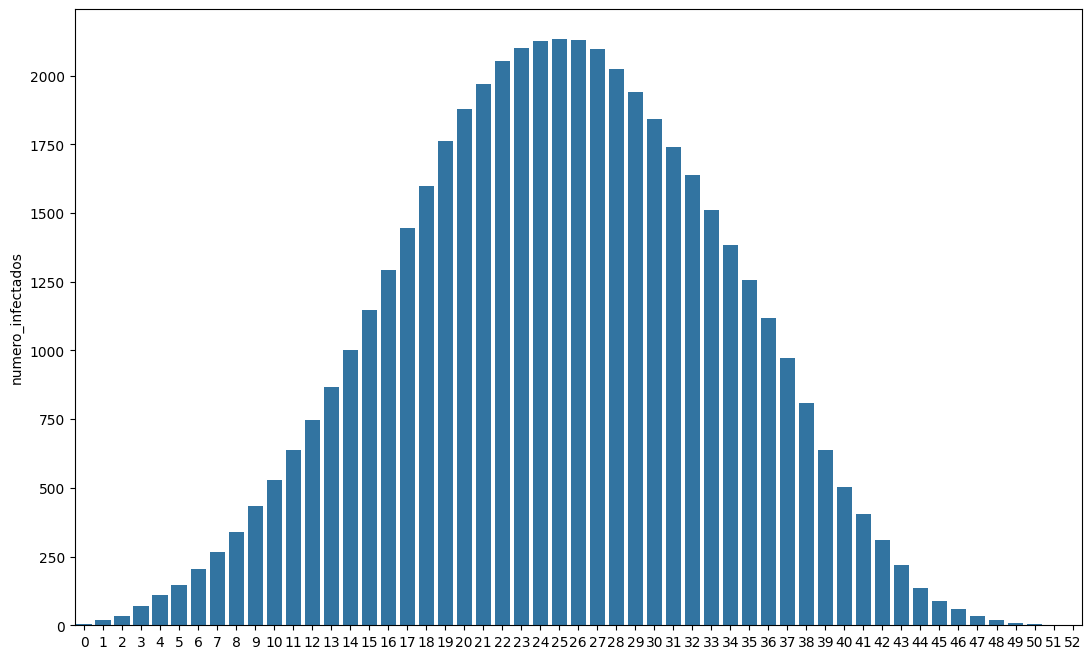

In [298]:
ax = sns.barplot(data=dados['numero_infectados'])
ax.figure.set_size_inches(13, 8)

# **Teste de normalidade**

Teste de normalidade shapiro, ja contido no scipy.stats

H0 - Há normalidade

H1 - Não normalidade ( p < alpha, nivel de significancia de 0.05)

In [299]:
def verificar_normalidade(coluna):
    stat, p = stats.shapiro(dados[coluna])
    alpha = 0.05
    if p > alpha:
        print(f'{coluna}: Distribuição Normal (p={p})')
    else:
        print(f'{coluna}: Distribuição NÃO Normal (p={p})')

In [300]:
for coluna in ['Sadios','Assintomáticos', 'Sintomáticos', 'Graves', 'Mortos', 'Curados']:
    verificar_normalidade(coluna)

Sadios: Distribuição NÃO Normal (p=1.5258784458183072e-08)
Assintomáticos: Distribuição NÃO Normal (p=4.2145748011535034e-05)
Sintomáticos: Distribuição NÃO Normal (p=8.111337956506759e-05)
Graves: Distribuição NÃO Normal (p=5.630982347071267e-09)
Mortos: Distribuição NÃO Normal (p=3.7438415034785066e-08)
Curados: Distribuição NÃO Normal (p=4.6715641133232566e-08)


In [301]:
    verificar_normalidade('numero_infectados')


numero_infectados: Distribuição NÃO Normal (p=4.783493932336569e-05)


In [302]:
def verificar_normalidade_h(coluna):
    plt.figure(figsize=(6, 3))
    sns.histplot(dados[coluna], kde=True, bins=10)
    plt.title(f'{coluna} - Histograma')
    plt.xlabel('Número')
    plt.ylabel('Frequência')
    plt.show()

    stat, p = stats.shapiro(dados[coluna])
    print(f'Statistic: {stat}, p-value: {p}')

    alpha = 0.05
    if p > alpha:
        print(f'{coluna}: Distribuição Normal (p={p}) \n')
    else:
        print(f'{coluna}: Distribuição NÃO Normal (p={p}) \n')

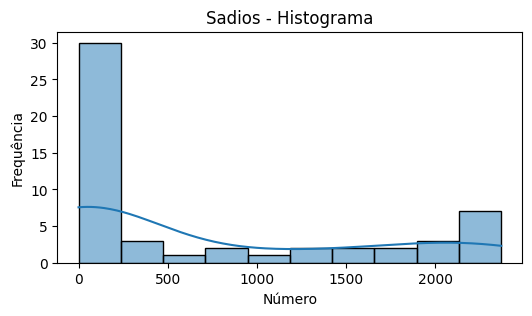

Statistic: 0.7298195958137512, p-value: 1.5258784458183072e-08
Sadios: Distribuição NÃO Normal (p=1.5258784458183072e-08) 



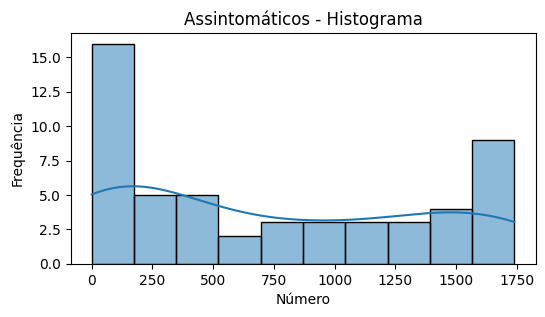

Statistic: 0.8724724054336548, p-value: 4.2145748011535034e-05
Assintomáticos: Distribuição NÃO Normal (p=4.2145748011535034e-05) 



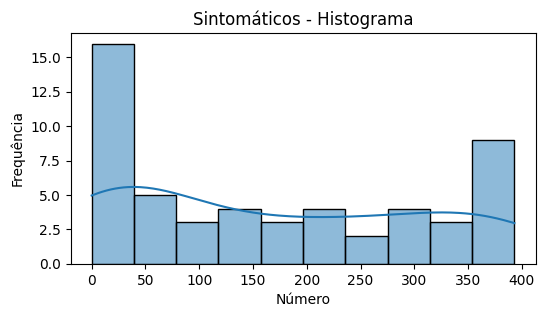

Statistic: 0.8816758990287781, p-value: 8.111337956506759e-05
Sintomáticos: Distribuição NÃO Normal (p=8.111337956506759e-05) 



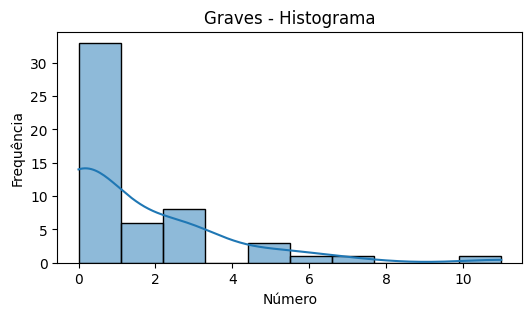

Statistic: 0.7071937322616577, p-value: 5.630982347071267e-09
Graves: Distribuição NÃO Normal (p=5.630982347071267e-09) 



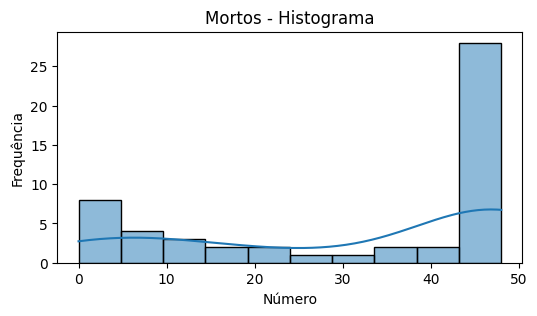

Statistic: 0.7492115497589111, p-value: 3.7438415034785066e-08
Mortos: Distribuição NÃO Normal (p=3.7438415034785066e-08) 



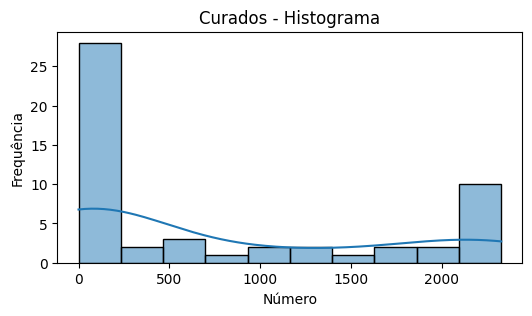

Statistic: 0.75385582447052, p-value: 4.6715641133232566e-08
Curados: Distribuição NÃO Normal (p=4.6715641133232566e-08) 



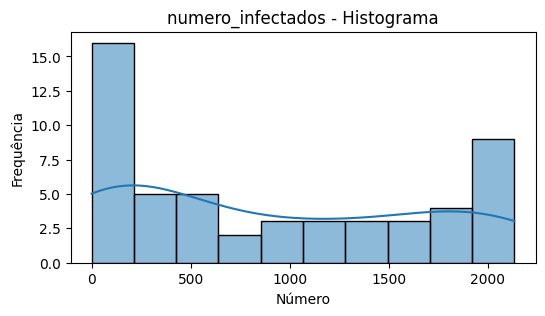

Statistic: 0.8742794394493103, p-value: 4.783493932336569e-05
numero_infectados: Distribuição NÃO Normal (p=4.783493932336569e-05) 



In [303]:
for colunax in ['Sadios','Assintomáticos', 'Sintomáticos', 'Graves', 'Mortos', 'Curados','numero_infectados']:
    verificar_normalidade_h(colunax)

# **Intervalo de Confiança**

In [304]:
dados['numero_infectados']

0        5
1       18
2       35
3       69
4      110
5      147
6      203
7      265
8      338
9      433
10     529
11     637
12     748
13     866
14    1001
15    1149
16    1294
17    1446
18    1600
19    1761
20    1878
21    1970
22    2052
23    2101
24    2127
25    2135
26    2131
27    2098
28    2023
29    1941
30    1842
31    1741
32    1640
33    1513
34    1384
35    1256
36    1119
37     971
38     810
39     637
40     503
41     404
42     309
43     219
44     136
45      89
46      59
47      33
48      21
49       9
50       4
51       1
52       0
Name: numero_infectados, dtype: object

In [305]:
infect_40 = random.choices(infect, k=40)

In [306]:
#infect_20 = infect.iloc[0:20]

In [307]:
infect_40

[529,
 89,
 2023,
 89,
 1640,
 1149,
 1119,
 203,
 2023,
 21,
 136,
 1842,
 1446,
 1878,
 35,
 2101,
 2131,
 637,
 136,
 265,
 35,
 404,
 1,
 2135,
 147,
 1842,
 309,
 9,
 1970,
 971,
 1294,
 219,
 69,
 637,
 265,
 1640,
 5,
 21,
 1640,
 1001]

In [308]:
import numpy as np
import scipy.stats as stats

amostra = infect_40
media = np.mean(amostra)
desvio_padrao = np.std(amostra)
graus_liberdade = len(amostra) - 1

intervalo_confianca = stats.t.interval(0.95, graus_liberdade, loc=media, scale=desvio_padrao / np.sqrt(len(amostra)))

In [309]:
media

852.65

In [310]:
intervalo_confianca

(600.6972193324841, 1104.6027806675158)

com 95% de certeza, refazendo os 40 passos, teremos uma média de infectados entre o intervalo acima

In [311]:
from scipy.stats import shapiro, norm

# **Teste da hipótese**

Teste de hipótese com 95% de significância com H0=µ0≥ 3/10000 para os
infectados sintomáticos em qualquer tempo? (3/10000 era o número de leitos de UTI
no Brasil por 10000 habitantes em março de 2020).

In [312]:

from statsmodels.stats.weightstats import ztest
import scipy.stats as stats
import warnings
from statsmodels.stats.weightstats import ttest_ind
warnings.filterwarnings('ignore')

In [313]:
def ttest_uni(amostra, popmean, alternative):
    n= len(amostra)
    tobs = (np.mean(amostra)-popmean)/np.sqrt(np.var(amostra, ddof=1)/n)
    if(alternative == "smaller"):
        pvalor = stats.t.cdf(tobs,n-1)
    if(alternative == "larger"):
        pvalor = 1 - stats.t.cdf(tobs,n-1)

    return print('(%.16f,%.16f)' % (tobs,pvalor)),pvalue

In [314]:
sint_part = sint_int.iloc[0:40]

In [315]:
sint_part

0       1
1       4
2       6
3      12
4      18
5      23
6      29
7      40
8      61
9      75
10     94
11    124
12    139
13    157
14    187
15    210
16    228
17    255
18    280
19    313
20    335
21    355
22    373
23    385
24    390
25    393
26    393
27    385
28    372
29    359
30    345
31    317
32    299
33    280
34    255
35    234
36    217
37    189
38    160
39    128
Name: Sintomáticos, dtype: int64

In [316]:
stats.ttest_1samp(sint_part,popmean = 0.0003)

TtestResult(statistic=9.832166380899045, pvalue=4.123565684583242e-12, df=39)

In [317]:
estatistics,pvalue = stats.ttest_1samp(sint_part,popmean = 0.0003)

In [318]:
estatistics

9.832166380899045

In [319]:
pvalue

4.123565684583242e-12

In [320]:
if pvalue <= 0.0003:
    print('pvalue inferior ao 0,0003 , quantidade de leitos na epoca, h0 rejeitada')
else:
    print('pvalue superior ao 0,0003 , h0 Não rejeitada, leitos suficiente')

pvalue inferior ao 0,0003 , quantidade de leitos na epoca, h0 rejeitada


# **Chi-Square. verificar independência entre assintomáticos e sintomáticos**

In [321]:
from scipy.stats import chi2_contingency

scipy.stats.chi2

In [322]:
contingencia = pd.crosstab(index=dados['Assintomáticos'], columns=dados['Sintomáticos'])
#print("\nTabela de Contingência Assintomáticos x Sintomáticos:\n", contingencia)

chi2, p, dof, expected = stats.chi2_contingency(contingencia)

print(f"\nChi-Square:")
print(f"Chi2: {chi2}")
print(f"p-valor: {p}")
print(f"Graus de Liberdade: {dof}")
#print(f"Frequências Esperadas:\n{expected}")

alpha = 0.05
print('alpha = ', alpha)
if p < alpha:
    print('\n', p , ' < ', alpha )
    print("Rejeitamos a hipótese nula. Dependencia entre Assintomáticos e Sintomáticos.")
else:
    print('\n' , p , ' > ', alpha )
    print("Não rejeitamos a hipótese nula. NÃO existe dependência significativa entre Assintomáticos e Sintomáticos.")


Chi-Square:
Chi2: 2296.6666666666665
p-valor: 0.21475747277186413
Graus de Liberdade: 2244
alpha =  0.05

 0.21475747277186413  >  0.05
Não rejeitamos a hipótese nula. NÃO existe dependência significativa entre Assintomáticos e Sintomáticos.


# **10. Se esta doença atacasse uma população de 216,422,446, qual seria o prognostico de mortes em 1 ano?**

Considerando as porcentagens utilizadas!

ao infectar temos:
    - 80% chance de ser Assintomático
    - 20% chance de ser Sintomático
    - 2% de ser sintomático grave
    - 80% de morte no caso de pacientes graves
    
    ( considerei 2% do total de infectados, ou seja ao ser infectado o individuo tem 2% de chance de ser grave,
    outro entedimento seria que dos sintomáticos teriamos 10% de ser grave (2% grave + 18% sintomatico = totalizando 20%sintomáticos)



Utilizando apenas esses percentuais, e considerando que todos os individuos sádios sejam infectados:

Total de graves seria 2% da populaçao de 216,422,446:
aproximadamente 4328448 obitos*

* Considerando que com as chances de 80% de graves irem a óbito é bastante elevado e como é um 'check' recorrente, as chances de um paciente grave ficar imune apos 20 passos é bastante pequena.

In [323]:
mortes_total = dados['Mortos'].max()
mortes_total

48

In [324]:
#dados['Mortos']

In [325]:
popul = n * n
popul

2500

In [326]:
taxa_mortalidade = mortes_total/popul
taxa_mortalidade

0.0192

In [327]:
populacao_teste = 216422446

In [328]:
prognostico_mortos = populacao_teste * taxa_mortalidade
prognostico_mortos

4155310.9631999996

csv-final

In [329]:
dados

,Passo,Assintomáticos,Sintomáticos,Graves,Mortos,Curados,Sadios,Resistentes,numero_infectados
0,1,4,1,0,0,0,2370.0,125.0,5
1,2,14,4,0,0,0,2357.0,125.0,18
2,3,29,6,0,0,0,2340.0,125.0,35
3,4,56,12,1,0,0,2306.0,125.0,69
4,5,91,18,1,1,0,2264.0,125.0,110
5,6,123,23,1,2,0,2226.0,125.0,147
6,7,174,29,0,3,0,2169.0,125.0,203
7,8,222,40,3,3,0,2107.0,125.0,265
8,9,275,61,2,5,0,2032.0,125.0,338
9,10,356,75,2,6,0,1936.0,125.0,433


In [330]:
for line in pattern:
    print(line)

 ######    ####    ##   ##
 ##         ##     ### ###
 ##         ##     #######
 ####       ##     ## # ##
 ##         ##     ##   ##
 ##         ##     ##   ##
 ##        ####    ##   ##
